# Prediction Part

### What we'll do here
- Set up the environment and imports
- Load and prepare data
- Cluster stations and aggregate demand
- Train and visualize forecasts
- Evaluate metrics and rebalancing

### How to run
1. Make sure the data files are in the data folder.
2. Run cells top-to-bottom.

### Table of Contents
- [2.1 Imports](#21-imports)
- [2.2 Load data](#22-load-data)
- [2.3 Spatial clustering (K=24)](#23-spatial-clustering-k24)
- [2.4 Elbow curve choice](#24-elbow-curve-choice)
- [2.5 Aggregate hourly demand](#25-aggregate-hourly-demand)
- [2.6 Modeling setup](#26-modeling-setup)
- [2.7 Forecast zooms (clusters & citywide)](#27-forecast-zoom)
- [2.8 Metrics snapshots](#28-metrics-snapshots)
- [2.9 Rebalancing analysis](#29-rebalancing-analysis)


### 2.1 Imports

Minimal imports and configuration for clustering and forecasting.


In [6]:
# Imports and configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path

# Configuration
DATA_PATH = Path("../data/trips_2018.csv")
TABLES = Path("./TABLES")
TABLES.mkdir(exist_ok=True)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.titlesize': 14})

### 2.2 Load data

Read station coordinates and streamed trip data for aggregation.


### 2.3 Spatial clustering (K=24)

Fit K-Means on station coordinates and label clusters.


In [7]:
# Load station coordinates and fit KMeans (K=24)
print("Step 1: Loading station coordinates for clustering...")

station_coords = {}
chunksize = 500_000
for chunk in pd.read_csv(
    DATA_PATH,
    chunksize=chunksize,
    usecols=['start_station_id', 'start_station_latitude', 'start_station_longitude'],
):
    chunk = chunk.dropna().drop_duplicates('start_station_id')
    for _, row in chunk.iterrows():
        sid = int(row['start_station_id'])
        if sid not in station_coords:
            station_coords[sid] = (row['start_station_latitude'], row['start_station_longitude'])

stations_df = pd.DataFrame.from_dict(station_coords, orient='index', columns=['lat', 'lon'])
stations_df.index.name = 'station_id'
print(f"Found {len(stations_df)} unique stations.")

K = 24
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
stations_df['cluster'] = kmeans.fit_predict(stations_df[['lat', 'lon']])

# Save cluster mapping
cluster_map = stations_df[['cluster']].reset_index().rename(columns={'index': 'station_id'})
cluster_map.to_csv(TABLES / 'cluster_map.csv', index=False)
print(f"Saved cluster_map.csv with {len(cluster_map)} rows.")


Step 1: Loading station coordinates for clustering...
Found 818 unique stations.
Saved cluster_map.csv with 818 rows.


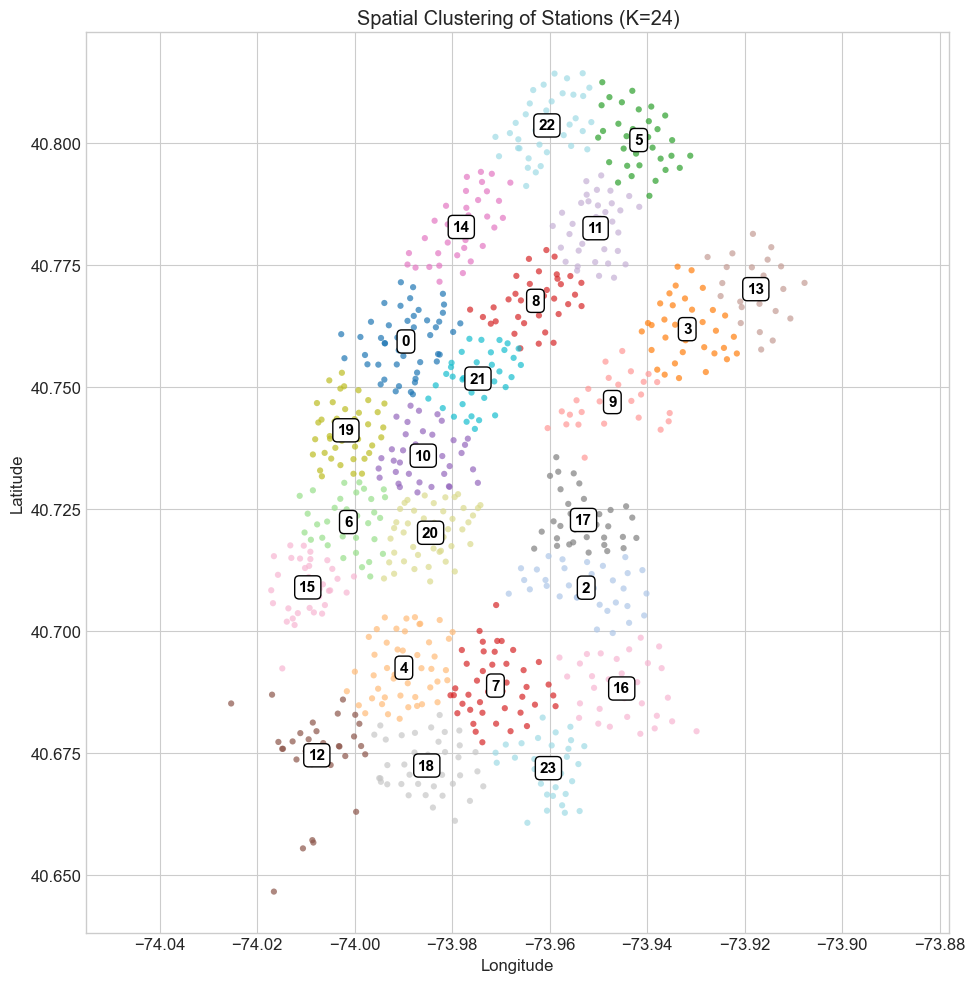

In [8]:
# --- VISUALIZATION: SPATIAL CLUSTERING ---


# Filter data to only include NYC area
nyc_stations = stations_df[
    (stations_df['lat'] > 40.60) & (stations_df['lat'] < 40.90) &
    (stations_df['lon'] > -74.05) & (stations_df['lon'] < -73.85)
]

plt.figure(figsize=(10, 10)) 

# Plot the points
plt.scatter(nyc_stations['lon'], nyc_stations['lat'], c=nyc_stations['cluster'], 
            cmap='tab20', s=20, alpha=0.7, edgecolor='none')


# We group by cluster to find the average lat/lon (the center) of each group
cluster_centers = nyc_stations.groupby('cluster')[['lat', 'lon']].mean()

# Annotate each cluster center with its cluster ID
for cluster_id, row in cluster_centers.iterrows():
    plt.text(
        row['lon'], row['lat'],     
        str(cluster_id),            
        fontsize=11, 
        weight='bold',
        color='black',
        ha='center', va='center',   
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=1)
    )

plt.title(f"Spatial Clustering of Stations (K={K})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal') 

plt.tight_layout()
plt.show()

### 2.4 Elbow curve choice

Check inertia across K to see the elbow point.


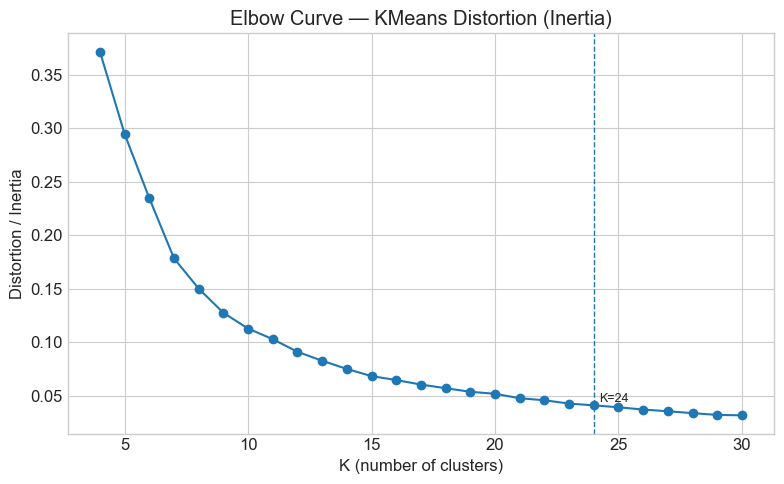

,K,inertia
0,4,0.371488
1,5,0.294607
2,6,0.234701
3,7,0.178513
4,8,0.150277
5,9,0.127678
6,10,0.113000
7,11,0.103016
8,12,0.091293
9,13,0.082935


In [9]:
lat0 = float(stations_df["lat"].mean())
X = np.column_stack([
    stations_df["lat"].to_numpy(),
    stations_df["lon"].to_numpy() * np.cos(np.deg2rad(lat0)),
])

K_VALUES = list(range(4, 31))
inertias = []
for K in K_VALUES:
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(K_VALUES, inertias, marker="o")
ax.set_title("Elbow Curve — KMeans Distortion (Inertia)")
ax.set_xlabel("K (number of clusters)")
ax.set_ylabel("Distortion / Inertia")

k_mark = 24
if k_mark in K_VALUES:
    ax.axvline(k_mark, linestyle="--", linewidth=1)
    ax.text(
        k_mark + 0.2,
        np.interp(k_mark, K_VALUES, inertias),
        f"K={k_mark}",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

display(pd.DataFrame({"K": K_VALUES, "inertia": inertias}).head(25))

### 2.5 Aggregate hourly demand

Stream trips and aggregate pickups/dropoffs by cluster.


In [10]:
# Aggregate hourly pickups/dropoffs by cluster
station_to_cluster = stations_df['cluster'].to_dict()

pickup_counts = {}
dropoff_counts = {}

for chunk in pd.read_csv(
    DATA_PATH,
    chunksize=chunksize,
    usecols=['starttime', 'stoptime', 'start_station_id', 'end_station_id'],
):
    chunk['start_hour'] = pd.to_datetime(chunk['starttime']).dt.floor('h')
    chunk['end_hour'] = pd.to_datetime(chunk['stoptime']).dt.floor('h')
    chunk['start_cluster'] = chunk['start_station_id'].map(station_to_cluster)
    chunk['end_cluster'] = chunk['end_station_id'].map(station_to_cluster)

    for (ts, cid), count in chunk.groupby(['start_hour', 'start_cluster']).size().items():
        pickup_counts[(ts, cid)] = pickup_counts.get((ts, cid), 0) + count
    for (ts, cid), count in chunk.groupby(['end_hour', 'end_cluster']).size().items():
        dropoff_counts[(ts, cid)] = dropoff_counts.get((ts, cid), 0) + count


# Convert dictionaries to DataFrames
### Trip timeline
df_pick = pd.Series(pickup_counts).reset_index()
df_pick.columns = ['ts', 'cluster_id', 'pickups']

df_drop = pd.Series(dropoff_counts).reset_index()
df_drop.columns = ['ts', 'cluster_id', 'dropoffs']

df_hourly = pd.merge(df_pick, df_drop, on=['ts', 'cluster_id'], how='outer').fillna(0)
df_hourly['cluster_id'] = df_hourly['cluster_id'].astype(int)
df_hourly = df_hourly.sort_values(['cluster_id', 'ts'])

# Reindex to fill missing hours
full_idx = pd.date_range(start=df_hourly['ts'].min(), end=df_hourly['ts'].max(), freq='h')
mux = pd.MultiIndex.from_product([df_hourly['cluster_id'].unique(), full_idx], names=['cluster_id', 'ts'])
df_hourly = df_hourly.set_index(['cluster_id', 'ts']).reindex(mux, fill_value=0).reset_index()

print(df_hourly.head())


   cluster_id                  ts  pickups  dropoffs
0           0 2018-01-01 00:00:00     15.0       5.0
1           0 2018-01-01 01:00:00     17.0      19.0
2           0 2018-01-01 02:00:00      8.0      11.0
3           0 2018-01-01 03:00:00      9.0       9.0
4           0 2018-01-01 04:00:00      6.0       3.0


### 2.6 Modeling setup

Baseline ridge on the highest-demand cluster.


In [11]:
# Simple ridge baseline on top-demand cluster
target_cluster = df_hourly.groupby('cluster_id')['pickups'].sum().idxmax()
print(f"Modeling representative cluster: {target_cluster}")

data = df_hourly[df_hourly['cluster_id'] == target_cluster].copy()
data = data.set_index('ts').sort_index()

# Lags and calendar features
data['lag_1h'] = data['pickups'].shift(1)
data['lag_24h'] = data['pickups'].shift(24)
data['lag_168h'] = data['pickups'].shift(168)

data['hour_of_day'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

data = data.dropna()

# Train = Jan–Oct, Test = Nov–Dec
train_mask = data.index.month <= 10
test_mask = data.index.month > 10

X_train = data.loc[train_mask, ['lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']]
y_train = data.loc[train_mask, 'pickups']
y_train_drop = data.loc[train_mask, 'dropoffs'] 

X_test = data.loc[test_mask, ['lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']]
y_test = data.loc[test_mask, 'pickups']
y_test_drop = data.loc[test_mask, 'dropoffs']

# Fit ridge models for pickups/dropoffs
model_pickups = Ridge(alpha=1.0)
model_pickups.fit(X_train, y_train)

model_dropoffs = Ridge(alpha=1.0)
model_dropoffs.fit(X_train, y_train_drop) 

# Predictions
x_test = X_test

y_pred = model_pickups.predict(x_test)
y_pred = np.maximum(y_pred, 0) 

y_pred_drop = model_dropoffs.predict(x_test)
y_pred_drop = np.maximum(y_pred_drop, 0)

# Quick metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R2: {r2:.3f}")


Modeling representative cluster: 0
RMSE: 87.34, R2: 0.794


### 2.7 Forecast zooms (clusters & citywide)

Clusters 0 and 6 plus citywide, first and second weeks of the test set.


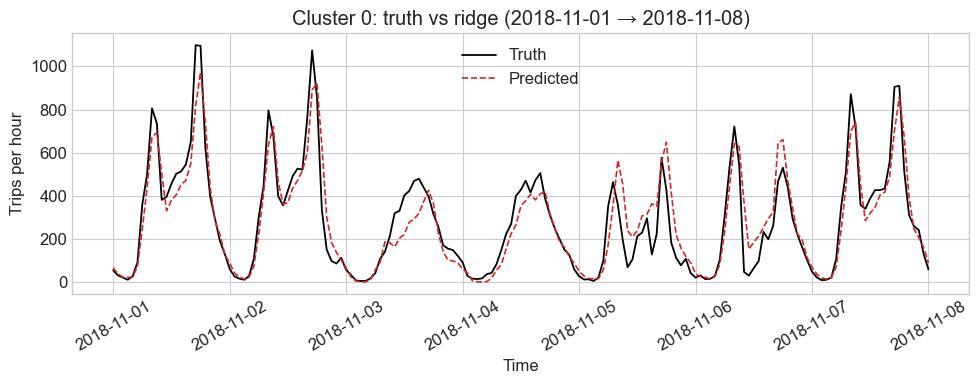

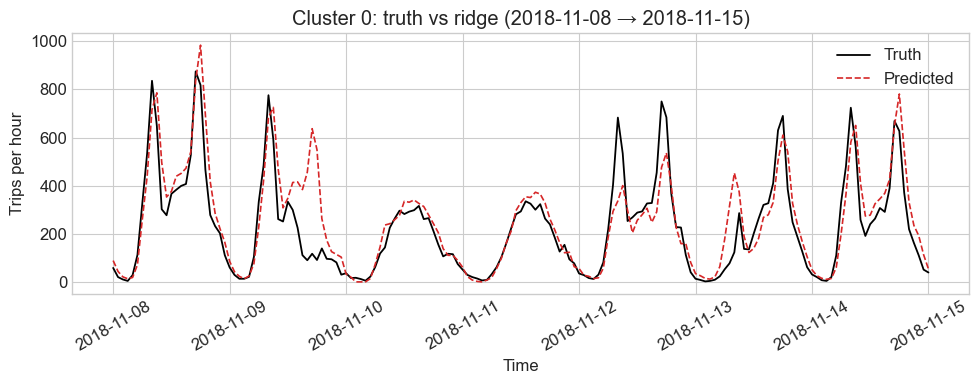

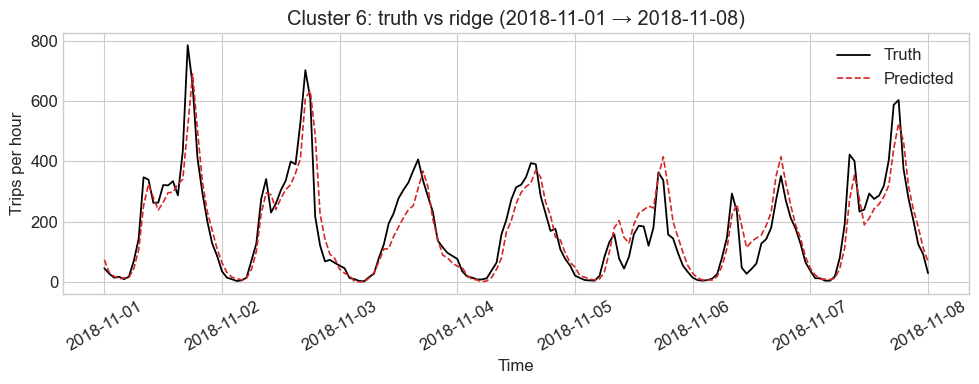

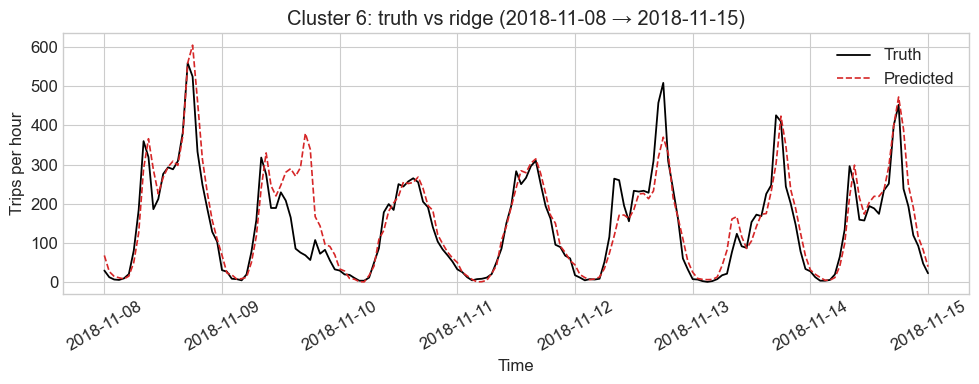

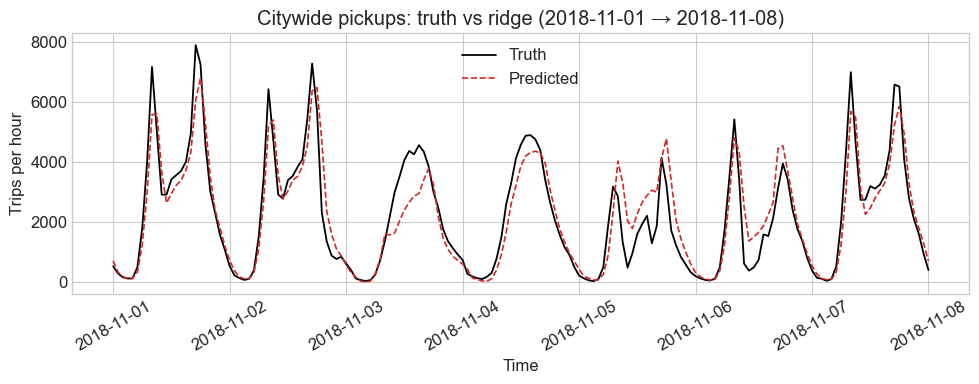

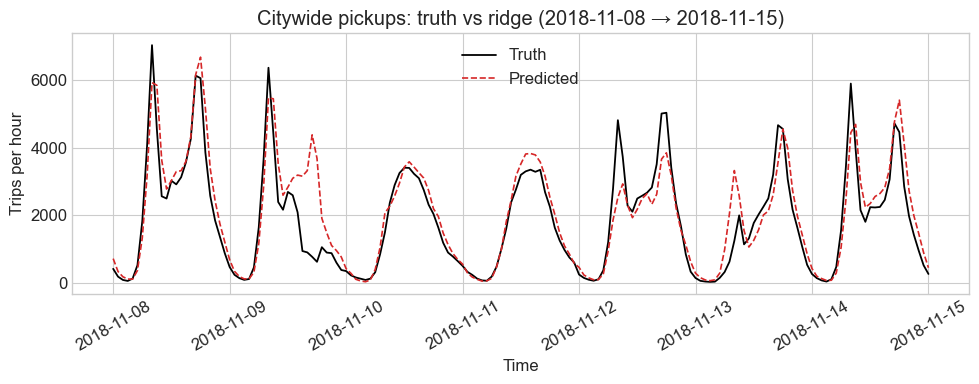

In [12]:
# --- VISUALIZATION OF PREDCITION MODEL ---
TRUTH_STYLE = {"color": "black", "linewidth": 1.3, "label": "Truth"}
PRED_STYLE = {"color": "tab:red", "linestyle": "--", "linewidth": 1.2, "label": "Predicted"}

LAGS = [1, 24, 168]
FEATURES = [f"lag_{L}" for L in LAGS] + ["is_weekend"]

dfp = df_hourly.copy()
dfp["month"] = dfp["ts"].dt.month
train_p = dfp[dfp["month"].between(1, 10)].drop(columns=["month"])
test_p  = dfp[dfp["month"].between(11, 12)].drop(columns=["month"])

def fit_predict(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    preds = []
    for cid in sorted(test_df["cluster_id"].unique()):
        train_c = train_df[train_df["cluster_id"] == cid].copy()
        test_c  = test_df[test_df["cluster_id"] == cid].copy()
        if train_c.empty or test_c.empty:
            continue

        combo = pd.concat([train_c.assign(is_test=False), test_c.assign(is_test=True)], ignore_index=True)
        combo = combo.sort_values("ts").copy()
        combo["y"] = combo[target].astype(float)
        for L in LAGS:
            combo[f"lag_{L}"] = combo["y"].shift(L)
        combo["is_weekend"] = combo["ts"].dt.dayofweek.isin([5,6]).astype("int8")

        train_rows = combo[~combo["is_test"]].dropna(subset=FEATURES + ["y"])
        if train_rows.empty:
            continue

        mdl = Ridge(alpha=1.0)
        mdl.fit(train_rows[FEATURES], train_rows["y"])

        test_rows = combo[combo["is_test"]].dropna(subset=FEATURES + ["y"])
        if test_rows.empty:
            continue

        yhat = mdl.predict(test_rows[FEATURES]).clip(min=0.0)
        preds.append(pd.DataFrame({"ts": test_rows["ts"], "cluster_id": int(cid), "y_hat": yhat}))

    if not preds:
        return pd.DataFrame(columns=["ts","cluster_id","y_hat"])
    return pd.concat(preds, ignore_index=True).sort_values(["ts","cluster_id"])

yhat_pickups = fit_predict(train_p, test_p, "pickups")

week1_start = pd.Timestamp("2018-11-01")
week1_end   = week1_start + pd.Timedelta(days=7)
week2_start = week1_end
week2_end   = week2_start + pd.Timedelta(days=7)

def plot_cluster_week(cid: int, start: pd.Timestamp, end: pd.Timestamp):
    truth = (test_p
             .loc[(test_p["cluster_id"]==cid) & (test_p["ts"].between(start, end))]
             .set_index("ts")["pickups"])
    pred = (yhat_pickups
            .loc[(yhat_pickups["cluster_id"]==cid) & (yhat_pickups["ts"].between(start, end))]
            .set_index("ts")["y_hat"]
            .reindex(truth.index))
    plt.figure(figsize=(10, 4))
    plt.plot(truth.index, truth.values, **TRUTH_STYLE)
    plt.plot(pred.index, pred.values, **PRED_STYLE)
    plt.title(f"Cluster {cid}: truth vs ridge ({start.date()} → {end.date()})")
    plt.xlabel("Time"); plt.ylabel("Trips per hour")
    plt.xticks(rotation=30)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_citywide(start: pd.Timestamp, end: pd.Timestamp):
    truth = (test_p
             .loc[test_p["ts"].between(start, end)]
             .groupby("ts")["pickups"]
             .sum()
             .sort_index())
    pred = (yhat_pickups
            .loc[yhat_pickups["ts"].between(start, end)]
            .groupby("ts")["y_hat"]
            .sum()
            .reindex(truth.index))
    plt.figure(figsize=(10, 4))
    plt.plot(truth.index, truth.values, **TRUTH_STYLE)
    plt.plot(pred.index, pred.values, **PRED_STYLE)
    plt.title(f"Citywide pickups: truth vs ridge ({start.date()} → {end.date()})")
    plt.xlabel("Time"); plt.ylabel("Trips per hour")
    plt.xticks(rotation=30)
    plt.legend()
    plt.tight_layout()
    plt.show()

for cid in [0, 6]:
    plot_cluster_week(cid, week1_start, week1_end)
    plot_cluster_week(cid, week2_start, week2_end)

plot_citywide(week1_start, week1_end)
plot_citywide(week2_start, week2_end)


### 2.8 Metrics snapshots

Quick error summaries for citywide and key clusters.


In [13]:
#(MAE/RMSE/WAPE)

def ridge_metrics(test_df, pred_df, target, cluster_ids=None, aggregate_citywide=False):
    df = test_df[["ts", "cluster_id", target]].merge(
        pred_df[["ts", "cluster_id", "y_hat"]],
        on=["ts", "cluster_id"],
        how="inner",
    )
    if cluster_ids is not None:
        df = df[df["cluster_id"].isin(cluster_ids)]
    if aggregate_citywide:
        df = df.groupby("ts", as_index=False).agg({target: "sum", "y_hat": "sum"})
    df["y_hat"] = df["y_hat"].clip(lower=0.0)

    y = df[target].to_numpy(dtype="float64")
    y_hat = df["y_hat"].to_numpy(dtype="float64")
    e = y - y_hat

    mae = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e ** 2)))
    wape = float(np.sum(np.abs(e)) / max(1e-9, np.sum(np.abs(y))))
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape}


print("Test metrics (Nov-Dec 2018) — pickups, ridge model")
print("  Citywide (sum over clusters):",
      ridge_metrics(test_p, yhat_pickups, "pickups", aggregate_citywide=True))
print("  Cluster 0:",
      ridge_metrics(test_p, yhat_pickups, "pickups", cluster_ids=[0]))
print("  Cluster 6:",
      ridge_metrics(test_p, yhat_pickups, "pickups", cluster_ids=[6]))


Test metrics (Nov-Dec 2018) — pickups, ridge model
  Citywide (sum over clusters): {'MAE': 391.3434024213055, 'RMSE': 615.3473637858466, 'WAPE': 0.25164888039035216}
  Cluster 0: {'MAE': 55.01720422338051, 'RMSE': 87.33588368443777, 'WAPE': 0.2819449482563492}
  Cluster 6: {'MAE': 30.51375350351242, 'RMSE': 47.950291297106084, 'WAPE': 0.2601679341262175}


### 2.9 Rebalancing analysis

Translate predicted flows into staging needs.


In [14]:
# Rebalancing optimization setup
analysis_day = '2018-11-07' 
day_mask = (y_test.index.strftime('%Y-%m-%d') == analysis_day)

pred_arrivals = y_pred_drop[day_mask]
pred_departures = y_pred[day_mask]
hours = y_test.index[day_mask]

net_flow = pred_arrivals - pred_departures
cumulative_inventory = np.cumsum(net_flow)
min_inventory = np.min(cumulative_inventory)
bikes_needed = abs(min(0, min_inventory))

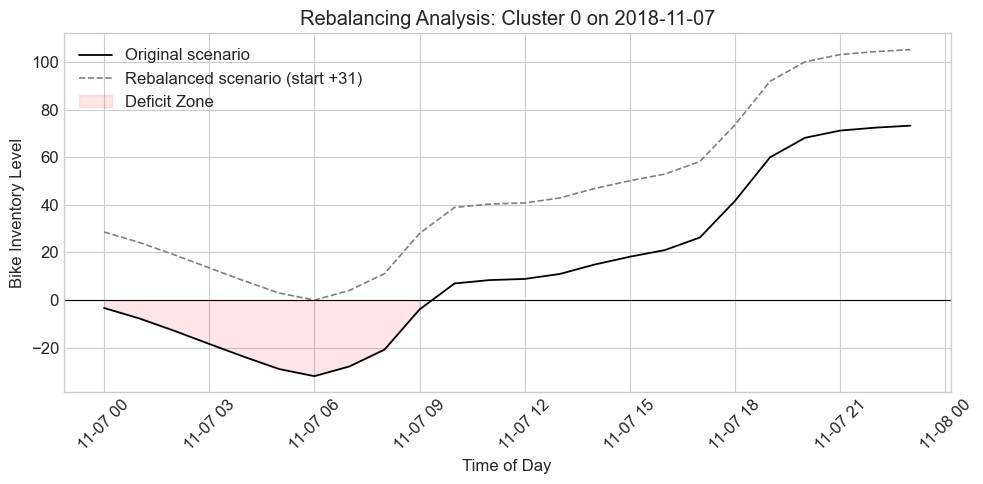

In [15]:
# --- VISUALIZATION: REBALANCING ---

df_rebal = pd.DataFrame({
    'Hour': hours,
    'Net_Flow': net_flow,
    'Inventory_Change': cumulative_inventory
})

# Safe inventory
df_rebal['Safe_Inventory'] = df_rebal['Inventory_Change'] + bikes_needed

plt.figure(figsize=(10, 5)) # Slightly wider for clarity

plt.plot(
    df_rebal['Hour'],
    df_rebal['Inventory_Change'],
    label='Original scenario',
    color='black',
    linewidth=1.3,
)

plt.plot(
    df_rebal['Hour'],
    df_rebal['Safe_Inventory'],
    label=f'Rebalanced scenario (start +{int(bikes_needed)})',
    color='gray',
    linestyle='--',
    linewidth=1.2,
)

plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

plt.fill_between(df_rebal['Hour'], df_rebal['Inventory_Change'], 0,
                 where=(df_rebal['Inventory_Change'] < 0),
                 color='red', alpha=0.1, label='Deficit Zone')

plt.title(f"Rebalancing Analysis: Cluster {target_cluster} on {analysis_day}")
plt.ylabel("Bike Inventory Level")
plt.xlabel("Time of Day")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
